<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/PV_LSTM_1118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import LSTM, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras import Model, Sequential
import json
from tensorflow.keras import Input, Model

In [2]:
# 데이터 로딩
df = pd.read_excel('pvdata.xlsx', sheet_name=0)

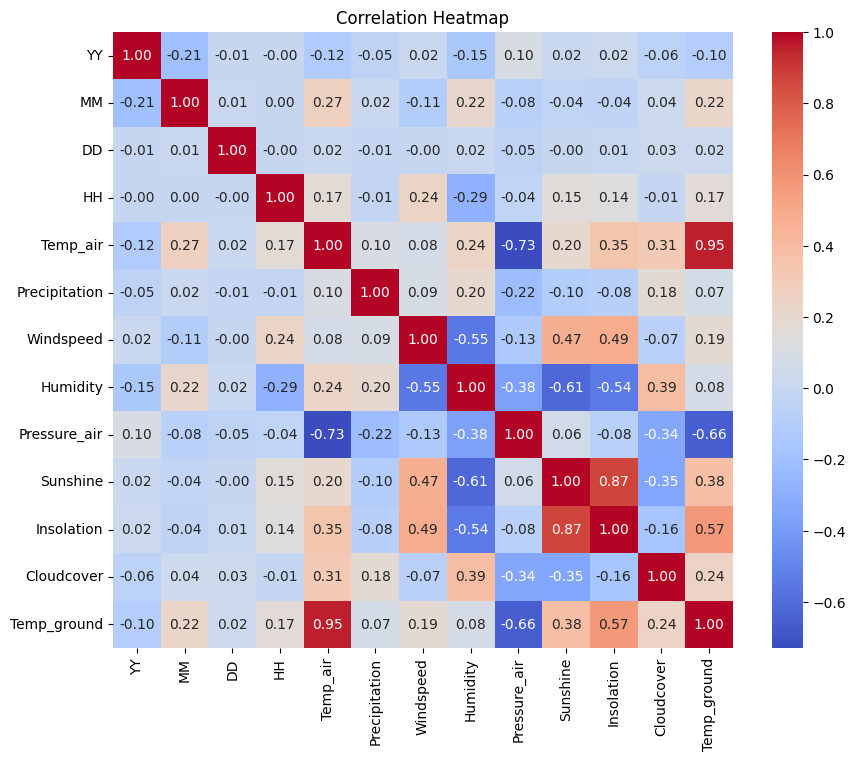

In [3]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[(df['Date'] >= '2023-04-01') & (df['Date'] < '2023-05-01')]

In [4]:
#3차원 데이터 만드는 함수
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [5]:
train_np_x = train.drop(columns=['Date', 'solarpower']).to_numpy()
train_np_y = train["solarpower"].to_numpy()
test_np_x = test.drop(columns=['Date', 'solarpower']).to_numpy()
test_np_y = test["solarpower"].to_numpy()

In [6]:
#3차원 변환
past_period = 72
future_target = 24
STEP = 1

x_train, y_train = multivariate_data(train_np_x, train_np_y, 0, None, past_period, future_target, STEP, single_step=True)
x_test, y_test = multivariate_data(train_np_x, train_np_y, 0, None, past_period, future_target, STEP, single_step=True)

train_np_x.shape, x_train.shape

((28464, 13), (28368, 72, 13))

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [12]:
x_train.shape[-2:]

(72, 13)

In [13]:
inputs = Input(shape=(x_train.shape[-2:]))
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(16, return_sequences=True,
                                          input_shape=x_train.shape[-2:], activation='softsign'))
multi_step_model.add(tf.keras.layers.LSTM(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
EVALUATION_INTERVAL = 200
EPOCHS = 40

multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS,
                                              steps_per_epoch=EVALUATION_INTERVAL,
                                              validation_data=test_data,
                                              validation_steps=50)



Epoch 1/40
200/200 [==============================] - 16s 69ms/step - loss: 0.1016 - val_loss: 0.1055
Epoch 2/40
200/200 [==============================] - 13s 66ms/step - loss: 0.1126 - val_loss: 0.1077
Epoch 3/40
 43/200 [=====>........................] - ETA: 8s - loss: 0.1218

200/200 [==============================] - 3s 15ms/step - loss: 0.1224 - val_loss: 0.1646


In [23]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
def create_time_steps(length):
  return list(range(-length, 0))

In [42]:
for x, y in test_data.take(3):
  print(len(x[0]))

72
72
72


In [46]:
for x, y in test_data.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

2/2 [==============================] - 0s 16ms/step


TypeError: ignored

<Figure size 1200x600 with 0 Axes>

In [30]:
list_x = list()
list_y = list()
for x, y in test_data.take(3):
  list_x.append(np.array(x))
  list_y.append(np.array(y))

In [33]:
predict_list = list()
for x, y in test_data.take(3):
  predict_multi_step_model.predict(x)[0]


[array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.01428571, 0.07923279],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00714286, 0.07500856],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.07067017],
         ...,
         [0.        , 0.        , 0.06666667, ..., 0.        ,
          0.        , 0.14636374],
         [0.        , 0.        , 0.06666667, ..., 0.        ,
          0.22142857, 0.141112  ],
         [0.        , 0.        , 0.06666667, ..., 0.        ,
          0.03571429, 0.13631693]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.00714286, 0.07500856],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.07067017],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.01428571, 0.06747346],
         ...,
         [0.        , 0.        , 0.06666667, ..., 0.        ,
          0.22142857, 0.

In [ ]:
# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)